In [ ]:
!nvidia-smi

Tue Apr 25 17:40:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install plot_keras_history
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import datetime 
import tensorflow_hub as hub 
from tensorflow.keras import layers
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for plot_keras_history: filename=plot_keras_history-1.1.38-py3-none-any.whl size=9470 sha256=fb7dd7071d9d1e72cfa427f1d964e09e6b67dad9a9c1bbdb0be92e96d86948dc
  Stored in directory: /root/.cache/pip/wheels/aa/0a/0f/0775c812151040fb695c0890d902810a9d69e1db50181e5328
  Created wheel for sanitize_ml_labels: filename=sanitize_ml_labels-1.0.50-py3-none-any.whl size=320515 sha256=d1d6c17ffe7c5a0a84358d0351399bb22cad5bea0da435dbedaeb83c1d0d3d2c
  Stored in directory: /root/.cache/pip/wheels/d2/50/d6/95e7c7713c3c1609e30a394d7431ffc11e4f7deb82d13ffceb
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl siz

In [3]:

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2023-04-26 11:03:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.203.128, 142.251.107.128, 74.125.141.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   165MB/s    in 1.0s    

2023-04-26 11:04:00 (165 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
# How many images in each folder
import os 
for dirpath,dirnames,filename in os.walk('10_food_classes_10_percent'):
  print(f'There are {len(dirnames)} directorires and {len(filename)} images in {dirpath}')

There are 2 directorires and 0 images in 10_food_classes_10_percent
There are 10 directorires and 0 images in 10_food_classes_10_percent/test
There are 0 directorires and 250 images in 10_food_classes_10_percent/test/steak
There are 0 directorires and 250 images in 10_food_classes_10_percent/test/grilled_salmon
There are 0 directorires and 250 images in 10_food_classes_10_percent/test/fried_rice
There are 0 directorires and 250 images in 10_food_classes_10_percent/test/pizza
There are 0 directorires and 250 images in 10_food_classes_10_percent/test/sushi
There are 0 directorires and 250 images in 10_food_classes_10_percent/test/hamburger
There are 0 directorires and 250 images in 10_food_classes_10_percent/test/chicken_curry
There are 0 directorires and 250 images in 10_food_classes_10_percent/test/ice_cream
There are 0 directorires and 250 images in 10_food_classes_10_percent/test/chicken_wings
There are 0 directorires and 250 images in 10_food_classes_10_percent/test/ramen
There are 

We have less data to train and more data to test

In [5]:


IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

print('Training Images:')
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          batch_size = BATCH_SIZE,
                                                          target_size = IMAGE_SHAPE,
                                                          class_mode = 'categorical')
print('Testing Images')
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = IMAGE_SHAPE,
                                             batch_size = BATCH_SIZE,
                                             class_mode = 'categorical')

Training Images:
Found 750 images belonging to 10 classes.
Testing Images
Found 2500 images belonging to 10 classes.


Setting Up callbacks: Callbacks are extra fucntionality you can add to your models to be performed during or after training.


In [6]:
# Create a tensoboard callback to monitor model perofrmances

def create_tensorboard_callback(dir_name,experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f'Saving Tensorboard log files to: {log_dir}')
  return tensorboard_callback

Creating models using tensorflowhub

In [7]:

resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [8]:
# Creating a model from url

def create_model(model_url,num_classes = 10):
  """
  Takes a tensorflow hub url and creates the keras sequential model with it.
  
  Args:
  model_url(str): A tensorflow hub feature extraction URL
  num_classes(int): Number of output neurons in output layer, should be equal to number of target classes. Default 10.

  Returns:
  An uncompiles keras sequential model with model_url as feature extractor layers and Dense outpul layer with num_classes output neurons. 
  """
  feature_extraction_layer = hub.KerasLayer(model_url,
                                            trainable = False,  # Freeze the already learned pattern
                                            name = 'feature_extraction_layer',
                                            input_shape = IMAGE_SHAPE +(3,))
  model = tf.keras.Sequential([
      feature_extraction_layer,
      layers.Dense(num_classes,activation = 'softmax', name = 'output_layer')
  ])                
  return model                          

Creating and testing resnet model

In [9]:
resnet_model = create_model(resnet_url,
                            num_classes = train_data_10_percent.num_classes)
# Compile the model

resnet_model.compile(loss = 'categorical_crossentropy',
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ['accuracy'])
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs = 5,
                                  steps_per_epoch= len(train_data_10_percent),
                                  validation_data= test_data,
                                  validation_steps = len(test_data),
                                  callbacks = [create_tensorboard_callback(dir_name = 'tensorflow_hub',
                                                                           experiment_name = 'resnet50v2')]
                                  )

Saving Tensorboard log files to: tensorflow_hub/resnet50v2/20230426-110503
Epoch 1/5
24/24 [==============================] - 38s 951ms/step - loss: 1.9800 - accuracy: 0.3240 - val_loss: 1.2990 - val_accuracy: 0.5884
Epoch 2/5
24/24 [==============================] - 19s 813ms/step - loss: 0.8825 - accuracy: 0.7480 - val_loss: 0.8821 - val_accuracy: 0.7252
Epoch 3/5
24/24 [==============================] - 20s 839ms/step - loss: 0.6203 - accuracy: 0.8280 - val_loss: 0.7973 - val_accuracy: 0.7400
Epoch 4/5
24/24 [==============================] - 25s 1s/step - loss: 0.4714 - accuracy: 0.8813 - val_loss: 0.7312 - val_accuracy: 0.7676
Epoch 5/5
24/24 [==============================] - 25s 1s/step - loss: 0.3772 - accuracy: 0.9120 - val_loss: 0.7037 - val_accuracy: 0.7708


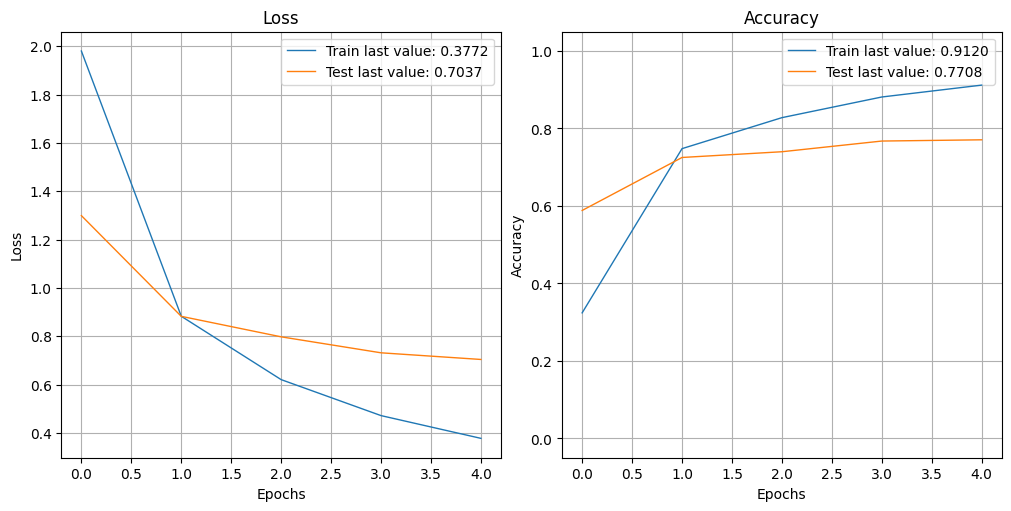

In [10]:
show_history(resnet_history)

In [11]:
efficientnet_model = create_model(efficientnet_url,
                            num_classes = train_data_10_percent.num_classes)
# Compile the model

efficientnet_model.compile(loss = 'categorical_crossentropy',
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ['accuracy'])
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                  epochs = 5,
                                  steps_per_epoch= len(train_data_10_percent),
                                  validation_data= test_data,
                                  validation_steps = len(test_data),
                                  callbacks = [create_tensorboard_callback(dir_name = 'tensorflow_hub',
                                                                           experiment_name = 'efficientnet_b0_feature_vector')]
                                  )

Saving Tensorboard log files to: tensorflow_hub/efficientnet_b0_feature_vector/20230426-110733
Epoch 1/5
24/24 [==============================] - 39s 1s/step - loss: 1.8658 - accuracy: 0.4160 - val_loss: 1.2897 - val_accuracy: 0.7360
Epoch 2/5
24/24 [==============================] - 20s 846ms/step - loss: 1.0626 - accuracy: 0.7600 - val_loss: 0.8653 - val_accuracy: 0.8172
Epoch 3/5
24/24 [==============================] - 18s 781ms/step - loss: 0.7578 - accuracy: 0.8320 - val_loss: 0.6929 - val_accuracy: 0.8524
Epoch 4/5
24/24 [==============================] - 18s 769ms/step - loss: 0.6092 - accuracy: 0.8653 - val_loss: 0.6055 - val_accuracy: 0.8612
Epoch 5/5
24/24 [==============================] - 18s 790ms/step - loss: 0.5095 - accuracy: 0.8933 - val_loss: 0.5566 - val_accuracy: 0.8644


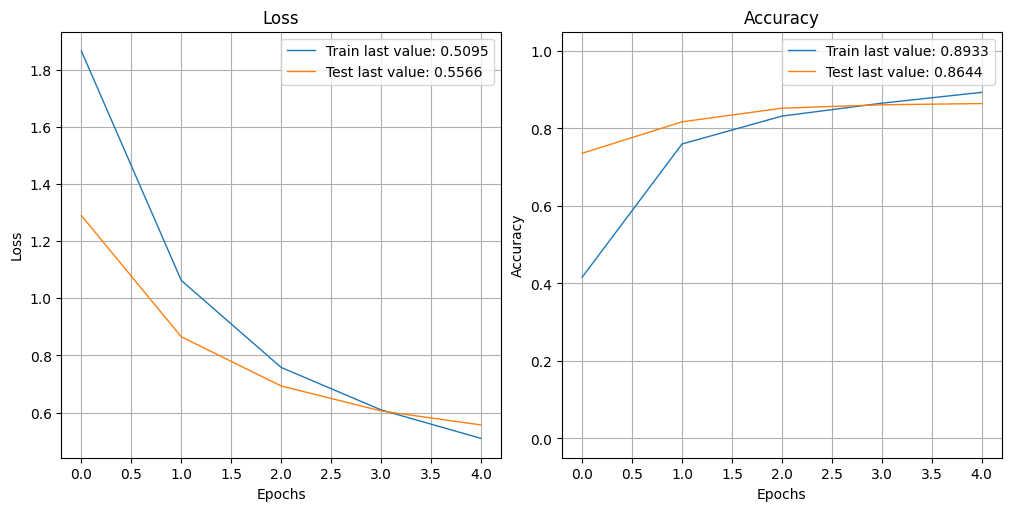

In [12]:
show_history(efficientnet_history)

In [14]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

2023-04-26 11:16:20.213718: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   DJRN-FSHH



New experiment created. View your TensorBoard at: https://tensorboard.dev/expe